# Neural Net Estimation Code for Surrogate Model for Sensitivity Analysis for Macroeconomics of Aging 
To run this notebook, use the `dynviz-dev` virtual conda environment, which can be built using the `environment.yml` file located in the same directory as this notebook (`conda env create -f environment.yml`).

This notebook builds a surrogate model for a sensitivity analysis tool for the macroeconomic impacts of improvements in biological aging. In this project, each simulation of a reform scenario of the OG-USA macroeconomic model takes about 30 minutes on a fairly powerful machine. From our simulations, we wanted to test the sensitivity of the results to six variables. If we wanted to look at all the permutations of the model for three values in each of the six input variables, that would equal 729 runs of the model.

If we assume that the equilibrium solutions are continuous and smooth between those points, we could fit a surrogate model function to those six input variables and an output variable (a regression model).

The following $X$ and $y$ data represent $N=27,472$ observations from a linear interpolant of 472 simulations of our model, each with different values of the $X$ input variables. These original 472 simulations represent all the permutations of the max and min values of the 6 input variables in $X$ ($N\times 6$ matrix) plus some remaining interior point observations. (The last 472 observations are the original 472 observations.)

The final caveat is that we need our final interpolant to be a tensorflow neural net because that is the only model that the `tensorflow.js` library can host on a web page.

**THE PROBLEM WE ARE STUCK ON (TRYING TO SOLVE)**

We assumed that a deep net would fit the data well and provide a smooth interpolant of our training data and test data. However, as can be seen below, our neural net does not fit the training data very well. We wanted to know if you have any insights into how to fit a neural net to these data better.

In [1]:
# imports
import numpy as np
import os
import pandas as pd
import scipy.interpolate as si
import pickle
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow import keras
import tensorflow_decision_forests as tfdf
from sklearn.model_selection import train_test_split

2025-05-18 20:35:28.442029: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 20:35:28.476823: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-18 20:35:28.476876: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-18 20:35:28.478169: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2025-05-18 20:35:28.484633: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-18 20:35:28.485718: I tensorflow/core/platform/cpu_feature_guard.cc:1

## 1. Prep the data
The following data contains 1 predicted variable $y$ which is an $N\times 1$ vector and one matrix of 6 input variables $X$ which is an $N\times 6$ matrix, where $N=27,472$. 

In [2]:
# Set the current directory as the cur_dir path
cur_dir = os.getcwd()
data_dir = os.path.join(cur_dir, 'data')

# Read in the data
X = np.loadtxt(os.path.join(data_dir, 'X.txt'), delimiter=',')
y = np.loadtxt(os.path.join(data_dir, 'y.txt'), delimiter=',').reshape(-1, 1)
print(f"The shape of X is {X.shape}")
print(f"The shape of y is {y.shape}")

The shape of X is (27472, 6)
The shape of y is (27472, 1)


In [3]:
# train-test split for model evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, y, train_size=0.8, random_state=42, shuffle=True
)

Here is the linear N-dimensional interpolant that we fit to our sparse runs of 472 data points in this $(X,y)$ space. This interpolant `interpolant_avg_diff()` is an estimated `scipy.interpolate.LinearNDInterpolator` object. This would be useful, e.g., if you want to use the surrogate model to generate new data points for each epoch.

In [4]:
interpolant_avg_diff = pickle.load(
    open(
        os.path.join(data_dir, "interpolant_avg_diff.pkl"), "rb"
    )
)
# using
prediction = interpolant_avg_diff(X_test)
print("Predictions = ", prediction[:5])

/tmp/ipykernel_398158/4103796048.py:1: DeprecationWarning: Please import `LinearNDInterpolator` from the `scipy.interpolate` namespace; the `scipy.interpolate.interpnd` namespace is deprecated and will be removed in SciPy 2.0.0.
  interpolant_avg_diff = pickle.load(


Predictions =  [[1540.55086271]
 [2460.84864787]
 [ 456.17321004]
 [1149.23911813]
 [1503.92608606]]


## 2. Set up the NN model

In [5]:
# set some hyperparameters
nodes_per_layer = 20 # multiplied by num inputs
activation_function = "relu"
num_epochs = 100
learning_rate = 0.001
# set up early stopping
callback = keras.callbacks.EarlyStopping(monitor='loss', patience=5000)

In [6]:
# Layer setting
num_input = X.shape[1]
num_hidden_layers = 7
num_hidden = np.zeros(num_hidden_layers)
# Start with more nodes per layer and decrease
for i in range(num_hidden_layers):
    num_hidden[i] = (nodes_per_layer - i * 2) * num_input
# num_hidden = nodes_per_layer * num_input
num_output = y.shape[1]
layers_dim = [num_input, num_hidden, num_output]
print("Dimensions of each layer are {}".format(layers_dim))

Dimensions of each layer are [6, array([120., 108.,  96.,  84.,  72.,  60.,  48.]), 1]


In [7]:
# Define the normalization function of the output
# Define the normalization function of the output
def normalize_output(data, data_max=None, data_min=None):
    """Normalizes the output data to a [0, 1] range."""
    if data_max is None:
        data_max = np.max(data)
    if data_min is None:
        data_min = np.min(data)
    return (data - data_min) / (data_max - data_min)


In [8]:
# Create a normalization layer for the inputs
norm_layer = tf.keras.layers.Normalization(input_shape=[num_input,], axis=-1)
# norm_layer = tf.keras.layers.Normalization(input_shape=[num_input,], axis=None)

# Initialize the weights
initializer = tf.keras.initializers.HeNormal(99)
# initializer = tf.keras.initializers.HeUniform()

# Adapt the layer to your training data
norm_layer.adapt(X_train)
nn = tf.keras.Sequential(
    [
        norm_layer,
        keras.layers.Dense(num_hidden[0], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[1], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[2], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[3], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[4], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[5], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_hidden[6], activation=activation_function, kernel_initializer=initializer),
        keras.layers.Dense(num_output, kernel_initializer=initializer),
    ]
)
print(nn.summary())

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 normalization (Normalizati  (None, 6)                 13        
 on)                                                             
                                                                 
 dense (Dense)               (None, 120)               840       
                                                                 
 dense_1 (Dense)             (None, 108)               13068     
                                                                 
 dense_2 (Dense)             (None, 96)                10464     
                                                                 
 dense_3 (Dense)             (None, 84)                8148      
                                                                 
 dense_4 (Dense)             (None, 72)                6120      
                                                        

In [9]:
loss_fn = tf.keras.losses.MeanSquaredError()
optimizer = tf.keras.optimizers.legacy.Adam(learning_rate=learning_rate)
nn.compile(optimizer=optimizer, loss=loss_fn, metrics=['mean_squared_error'])

## 3. Train the NN model

In [10]:
y_max_train = y_train.max()
y_min_train = y_train.min()
history = nn.fit(
    X_train, normalize_output(y_train),
    epochs=num_epochs,
    callbacks=[callback],
    # sample_weight=sample_weights,
    batch_size=32,
    validation_data=(X_test,  normalize_output(y_test, y_max_train, y_min_train)),
    validation_freq=5,   # Evaluate every 5 epochs
    verbose=1
)

Epoch 1/100
687/687 [==============================] - 2s 2ms/step - loss: 0.0045 - mean_squared_error: 0.0045
Epoch 2/100
687/687 [==============================] - 2s 2ms/step - loss: 4.8090e-04 - mean_squared_error: 4.8090e-04
Epoch 3/100
687/687 [==============================] - 2s 2ms/step - loss: 3.0310e-04 - mean_squared_error: 3.0310e-04
Epoch 4/100
687/687 [==============================] - 2s 2ms/step - loss: 2.3339e-04 - mean_squared_error: 2.3339e-04
Epoch 5/100
687/687 [==============================] - 2s 3ms/step - loss: 2.0115e-04 - mean_squared_error: 2.0115e-04 - val_loss: 1.9130e-04 - val_mean_squared_error: 1.9130e-04
Epoch 6/100
687/687 [==============================] - 2s 2ms/step - loss: 1.6831e-04 - mean_squared_error: 1.6831e-04
Epoch 7/100
687/687 [==============================] - 2s 2ms/step - loss: 1.9413e-04 - mean_squared_error: 1.9413e-04
Epoch 8/100
687/687 [==============================] - 2s 2ms/step - loss: 1.4554e-04 - mean_squared_error: 1.4554e

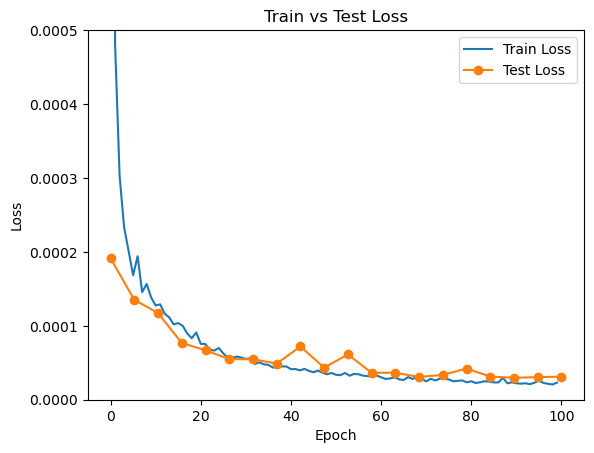

In [11]:
# Plot training and validation loss
plt.plot(np.arange(num_epochs), history.history['loss'], label='Train Loss')
plt.plot(
    np.linspace(0, num_epochs, num=int(np.ceil(num_epochs/5))),
    history.history['val_loss'], label='Test Loss', marker='o'
)
plt.ylim(0, 0.0005)
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Train vs Test Loss')
plt.legend()
plt.show()

## 4. Check the fit of the model

In [12]:
nn.evaluate(X,  normalize_output(y, y_max_train, y_min_train), verbose=2)

859/859 - 1s - loss: 2.1916e-05 - mean_squared_error: 2.1916e-05 - 1s/epoch - 1ms/step


[2.191568273701705e-05, 2.191568273701705e-05]

### 4.1. Checking against the original data

In [13]:
output_variable = "avg_diff"
predictions_normed = nn.predict(X)
# Rescale the predictions
predictions = predictions_normed * (y_max_train - y_min_train) + y_min_train
y_pred = predictions
y_diff = y - y_pred
print(
    f"The mean abs diff between y and y_pred is {np.absolute(y_diff).mean()}."
)
print(f"The max diff between y and y_pred is {y_diff.max()}.")
print(f"The min diff between y and y_pred is {y_diff.min()}.")

859/859 [==============================] - 1s 1ms/step
The mean abs diff between y and y_pred is 15.792049256049639.
The max diff between y and y_pred is 215.51506370501784.
The min diff between y and y_pred is -313.25722740240917.


In [14]:
normalization_layer = nn.get_layer('normalization')
mean = normalization_layer.mean.numpy()
variance = normalization_layer.variance.numpy()
print("Mean: ", mean)
print("Std dev: ", variance**(1/2))

Mean:  [[54.774956   8.350455   8.384443   1.8986119  1.9025313  0.5333266]]
Std dev:  [[5.9505095  4.8013268  4.798767   1.4162183  1.4184183  0.39660984]]


### 4.2. Check closeness to runs used in Silver Linings Book

There are a number of runs included in the Silver Linings book that we want to hit **extremely** closely. These happen to be the last 472 observations of the $X$ and $y$ data objects. We can check how close the surrogate model is to these runs.

In [15]:
# Load model
X_book = X[-472:, :]
y_book = y[-472:, :]

# predict using the model
y_book_pred_norm = nn.predict(X_book)
y_book_pred = y_book_pred_norm * (y_max_train - y_min_train) + y_min_train
y_book_diff = y_book - y_book_pred
print(
    f"The mean abs diff between y_book_pred and y_book " +
    f"is {np.absolute(y_book_diff).mean()}."
)
print(f"The max diff between y_book_pred and y_book is {y_book_diff.max()}.")
print(f"The min diff between y_book_pred and y_book is {y_book_diff.min()}.")


15/15 [==============================] - 0s 1ms/step
The mean abs diff between y_book_pred and y_book is 19.13597747169837.
The max diff between y_book_pred and y_book is 80.8457985770549.
The min diff between y_book_pred and y_book is -76.27483755019.
